# Create and run a local RAG pipline from scratch

The goal is to build a RAG (Retrieval Augmented Generation) pipline from *schatch*.
I want to be able to open a PDF file and ask questions of it, and have them answered by the LLM.

# Steps:
1. Open a PDF
2. Text splitting/chunking (Format the PDF ready for an embedding model)
3. Embed all the chunks
4. Build a system that user vector search to find the relavent text
5. Create prompt
6. Generate an answer

## 1 . Open a PDF

In [1]:
import os
import requests
import torch

In [2]:
# Set up the device
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1.1 Download the PDF

In [3]:
def download_pdf(filename:str,
                 dir_path: str,
                 pdf_url:str):
  """
    Download PDF into the given firectory. If the firector do not exist, it will be created before the download

    Args:
      filename = the pdf will be save with this name (Ex: 'example_file_name.pdf')
      dir_path = pdf will be save in this dir (Ex: './example_dir/')
      pdf_url = direct url to the pdf file (Ex: 'https://nibmehub.com/opac-service/pdf/read/Business%20Analysis.pdf')
  """
  if not os.path.exists(dir_path):
    # Create the directory for the PDF
    os.makedirs(dir_path)
    print(f"[INFO] {dir_path} directory created")

  if not os.path.exists(dir_path + filename):
    # Send GET request to the url
    response = requests.get(pdf_url)
    if response.status_code == 200:
      # Open and save the pdf
      with open(dir_path + filename, "wb") as file:
        file.write(response.content)
      print(f"[INFO] {filename} downloaded")
    else:
      print(f"[ERROR] {filename} could not be downloaded")
  else:
    print("[INFO] PDF file exist")


filename = "businessAnalysis.pdf"
dir_path="./pdf_source/"
pdf_url = "https://nibmehub.com/opac-service/pdf/read/Business%20Analysis.pdf"
full_pdf_path = dir_path + filename

download_pdf(filename=filename,
             dir_path=dir_path,
             pdf_url=pdf_url)

[INFO] ./pdf_source/ directory created
[INFO] businessAnalysis.pdf downloaded


### 1.2 Open and read the PDF per pages

Will use an NPL (natural language processing) libary to break the text into sentence. (spaCy)

Source: https://spacy.io/usage

In [4]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 103.6 MB/s eta 0:00:00


In [5]:
# Create NPL to split the text into sentences
from spacy.lang.en import English

nlp = English()
# Add module to recognice sentences
nlp.add_pipe("sentencizer")

In [6]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path:str):
  doc = fitz.open(pdf_path)
  pages_and_text = []

  for page_number, page in tqdm(enumerate(doc)):
    text = text_formatter(page.get_text())
    pages_and_text.append({"page_number": page_number + 1,
                           "page_char_number": len(text),
                           "page_word_number": len(text.split(" ")),
                           "page_sentence_number": len(text.split(". ")),
                           "page_token_number": len(text) / 4, # Most of the time 4 chart is 1 token
                           "text" : text})

  return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path=full_pdf_path)

0it [00:00, ?it/s]

In [7]:
for item in tqdm(pages_and_text):
  item["sentences"] = list(nlp(item["text"]).sents)
  # Make sure all sentences are strings (deault tyoe is spaCy datatype)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]
  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/311 [00:00<?, ?it/s]

In [8]:
# Turn it into dataframe
import pandas as pd
df = pd.DataFrame(pages_and_text)


In [9]:
# Lets see what is the number of the mean token per pages.
df.describe().round(2)

,page_number,page_char_number,page_word_number,page_sentence_number,page_token_number,page_sentence_count_spacy
count,311.00,311.00,311.00,311.00,311.00,311.00
mean,156.00,2313.66,387.05,16.27,578.41,16.71
std,89.92,828.49,143.33,7.50,207.12,7.66
min,1.00,0.00,1.00,1.00,0.00,0.00
25%,78.50,1758.50,294.00,12.00,439.62,12.00
50%,156.00,2358.00,396.00,16.00,589.50,17.00
75%,233.50,3002.50,502.00,21.00,750.62,22.00
max,311.00,3985.00,704.00,51.00,996.25,51.00


## 2 . Text splitting/chunking (Format the PDF ready for an embedding model)

Based on the describtion our pdf contains 578 token mean.

Have to make sure that our token number is not over the embedding model capacity and more then the model token limitation.

Source:
* Hugginface LLM models description (token limitation): https://huggingface.co/spaces/mteb/leaderboard


In [10]:
NUMBER_OF_CHUNK = 5

def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
                """
                Splits the input_list into sublists of size slice_size (or as close as possible).

                For example, a list of 17 sentences would be split into two lists of [[10], [7]]
                """
                return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Split sentences into chunks
for item in tqdm(pages_and_text):
  item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                       slice_size=NUMBER_OF_CHUNK)
  item["number_of_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/311 [00:00<?, ?it/s]

### 2.1 Spliting each chunk into its own item

In [11]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/311 [00:00<?, ?it/s]

1163

In [12]:
import random
random.sample(pages_and_chunks, k=1)

[{'page_number': 100,
  'sentence_chunk': 'The extent of the business analyst role will depend upon the lifecycle and approach adopted on the project. Implementing the business changes The delivery of the business solution will need to consider aspects such as the emotional impact of change and the realisation of the business benefits. These issues are discussed in Chapter 14. The business analyst may be heavily involved in tasks such as designing and documenting the new tasks and procedures, supporting user acceptance testing and reviewing benefits to assess their realisation. Stage summary Procedure yy Decide the lifecycle and approach to be adopted yy Design and develop the business change solution yy Support the planning and implementation, in particular the development of the required learning materials and the delivery of training for the business staff yy Review the predicted benefit yy Identify any actions required to realise the benefits Inputs yy Business change process and o

In [13]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1163.00,1163.00,1163.00,1163.00
mean,156.26,610.97,96.52,152.74
std,84.76,329.10,49.44,82.28
min,3.00,2.00,1.00,0.50
25%,82.50,434.50,69.00,108.62
50%,159.00,624.00,99.00,156.00
75%,229.00,764.50,121.00,191.12
max,310.00,3487.00,451.00,871.75


In [14]:
# Filter our the chunks which has too low token number (20) (They dont seem to offer to much information)
old_len = len(pages_and_chunks)
min_token = 20
pages_and_chunks = df[df["chunk_token_count"] > min_token].to_dict(orient="records")
print(f"[INFO] chunks with less then {min_token} token has been removed, length of chunks changed from {old_len} to {len(pages_and_chunks)}")

[INFO] chunks with less then 20 token has been removed, length of chunks changed from 1163 to 1108


## 3 . Embed all the chunks

For embed the text we will user sentence-transformert libary (all-mpnet-base-v2)

Source: https://www.sbert.net/docs/installation.html

To check out more embedding model: https://huggingface.co/spaces/mteb/leaderboard

In [15]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 17.1 MB/s eta 0:00:00


In [16]:
from sentence_transformers import util, SentenceTransformer
# Create embedding model
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
%%time
embedding_model.to("cuda")

for item in tqdm(pages_and_chunks):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1108 [00:00<?, ?it/s]

CPU times: user 44.7 s, sys: 322 ms, total: 45 s
Wall time: 17.1 s


In [28]:
# Save the embedding with all the usefull information
text_chunks_and_embedding_df = pd.DataFrame(pages_and_chunks)
text_chunks_and_embedding_df.to_csv("./pages_and_chunks.csv", index=False)

### 3.1 Encode the query

To find more embedding model: https://huggingface.co/spaces/mteb/leaderboard

In [30]:
import numpy as np

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embedding to torch tensor and send to device
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1108, 768])

### 3.2 Make a similarity search

In [31]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [40]:
def get_most_relavent_resources(query:str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    dot_scores = util.dot_score(query_embedding, embeddings)[0]

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices


## 4 . Build a system that user vector search to find the relavent text

To find more model: https://huggingface.co/docs/transformers/index

I will user gemma-7b-it: https://huggingface.co/google/gemma-7b-it

### 4.1 Log in into hugginface

In [34]:
!pip install huggingface_hub

In [35]:
from huggingface_hub import login

# Replace 'your_token_here' with the actual API token you got from Hugging Face
login(token="")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### 4.2 Download the LLM

In [36]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "google/gemma-7b-it"

# Create a tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Instantiate the model
gemma_model =  AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_name,
                                   torch_dtype=torch.float16,
                                   low_cpu_mem_usage=False,
                                   )

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 5 . Create prompt

In [42]:
def promt_format(query: str,
                 context_items: list[dict]) -> str:
                  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

                  base_promt = """
                  Based on the following context items, please answer the query.
                  Don't return the thinking, only return the answer.
                  Make sure your answers are as explanatory as possible.
                  \nNow use the following context items to answer the user query:
                  {context}
                  \nRelevant passages: <extract relevant passages from the context here>
                  User query: {query}
                  Answer:
                  """

                  base_promt = base_promt.format(context=context, query=query)

                  template = [
                      {"role": "user",
                      "content": base_promt}
                  ]

                  prompt = tokenizer.apply_chat_template(conversation=template,
                                          tokenize=False,
                                          add_generation_prompt=True)
                  return prompt

## 6 . Generate an answer

In [55]:
import matplotlib.pyplot as plt

def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = get_most_relavent_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = promt_format(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate an output of tokens
    outputs = gemma_model.to(device).generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items


def show_relavent_page(context):
  page_number = context[0]["page_number"]
  # Open the pdf with fitz
  doc = fitz.open(full_pdf_path)
  page = doc.load_page(page_number - 1)

  # Get the image of the page
  img = page.get_pixmap(dpi=300)

  # Convert the Pixmap to a numpy array
  img_array = np.frombuffer(img.samples_mv,
                            dtype=np.uint8).reshape((img.h, img.w, img.n))

  # Loag the page of the most
  plt.figure(figsize=(13,10))
  plt.imshow(img_array)
  plt.axis("off")
  plt.show()


In [59]:
query = "What is the Porter’s value chain?"
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)
answer

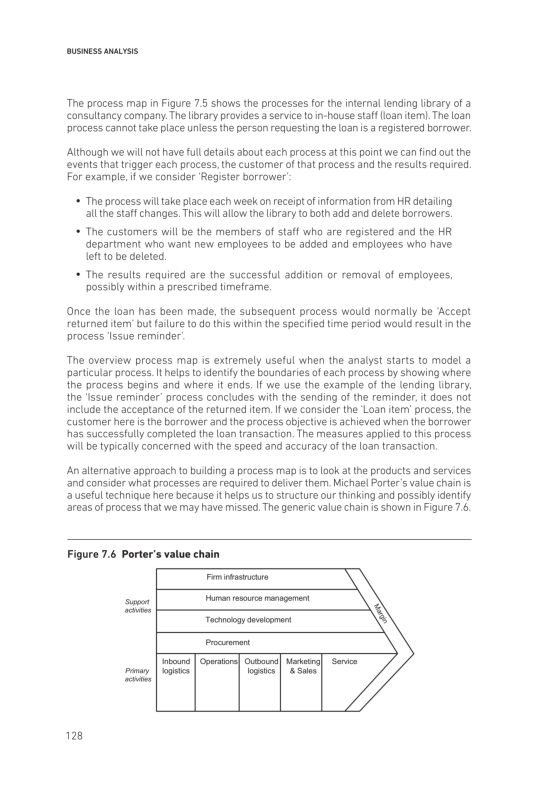

In [62]:
# Show the msot relavent page based on the question
show_relavent_page(context_items)